In [0]:
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import seaborn as sns

from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
% matplotlib inline


import sklearn.metrics as metrics


In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
with open('drive/My Drive/1 myself/springboard 2019-20/Take home/logins.json') as f:
  data = json.load(f)

# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}
print(data)

{'login_time': ['1970-01-01 20:13:18', '1970-01-01 20:16:10', '1970-01-01 20:16:37', '1970-01-01 20:16:36', '1970-01-01 20:26:21', '1970-01-01 20:21:41', '1970-01-01 20:12:16', '1970-01-01 20:35:47', '1970-01-01 20:35:38', '1970-01-01 20:47:52', '1970-01-01 20:26:05', '1970-01-01 20:31:03', '1970-01-01 20:34:46', '1970-01-01 20:36:34', '1970-01-01 20:39:25', '1970-01-01 20:40:37', '1970-01-01 20:34:58', '1970-01-01 20:43:59', '1970-01-01 20:47:46', '1970-01-01 20:46:34', '1970-01-01 20:56:07', '1970-01-01 20:49:12', '1970-01-01 20:59:06', '1970-01-01 20:59:59', '1970-01-01 21:15:01', '1970-01-01 21:09:24', '1970-01-01 21:19:24', '1970-01-01 21:20:53', '1970-01-01 21:29:19', '1970-01-01 21:58:05', '1970-01-01 21:51:51', '1970-01-01 21:59:40', '1970-01-01 22:08:34', '1970-01-01 22:02:51', '1970-01-01 21:58:32', '1970-01-01 22:02:31', '1970-01-01 22:05:32', '1970-01-01 22:02:46', '1970-01-01 22:10:28', '1970-01-01 22:11:58', '1970-01-01 22:01:05', '1970-01-01 22:19:10', '1970-01-01 22:16:

## Part 1 ‑ Exploratory data analysis

In [0]:

df = pd.read_json ('drive/My Drive/1 myself/springboard 2019-20/Take home/logins.json')

In [0]:
df.set_index('login_time', inplace= True)

In [0]:
# Count login time in 15min interval 
df['count'] = 1
data = df.resample('15T').sum()

(array([719163., 719177., 719194., 719208., 719222., 719236., 719253.,
        719267.]), <a list of 8 Text major ticklabel objects>)

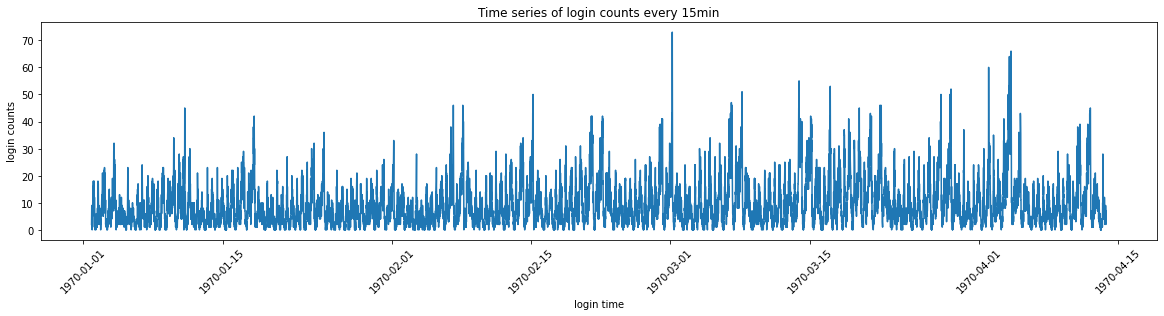

In [122]:
plt.figure(figsize=(20,4))
plt.title('Time series of login counts every 15min')
plt.plot(data)
plt.xlabel('login time')
plt.ylabel('login counts')
plt.xticks(rotation=45)

In [123]:
data.max()

count    73
dtype: int64

In [124]:
#pandas.DatetimeIndex.dayofweek ; The day of the week with Monday=0, Sunday=6.
data[data == 73].index[0].dayofweek

3

In [125]:
s = pd.date_range('1970-01-01', '2017-01-08', freq='D').to_series()
s.dt.dayofweek

1970-01-01    3
1970-01-02    4
1970-01-03    5
1970-01-04    6
1970-01-05    0
             ..
2017-01-04    2
2017-01-05    3
2017-01-06    4
2017-01-07    5
2017-01-08    6
Freq: D, Length: 17175, dtype: int64

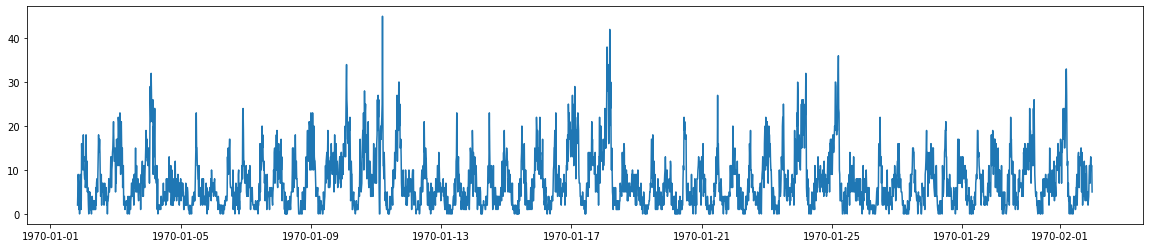

In [126]:
# monthly cycle
plt.figure(figsize=(20,4))
plt.plot(data['1970-01-01':'1970-02-01'])


(array([719164., 719165., 719166., 719167., 719168., 719169., 719170.]),
 <a list of 7 Text major ticklabel objects>)

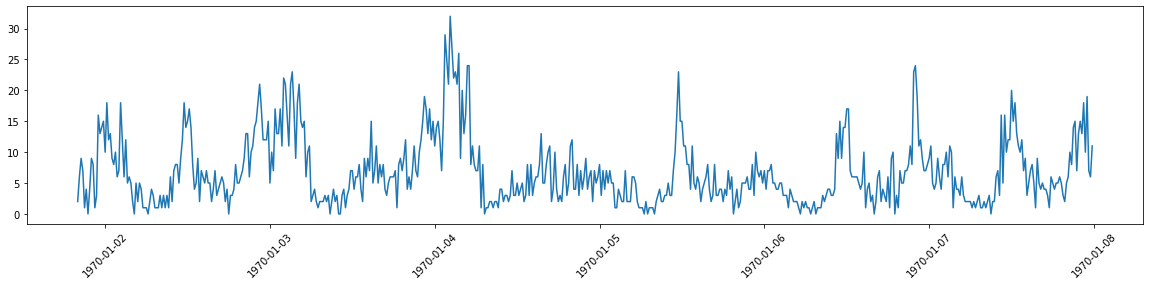

In [127]:
# weekly cycle
plt.figure(figsize=(20,4))
plt.plot(data['1970-01-01':'1970-01-07'])
plt.xticks(rotation=45)




> A: We see the peak on Sunday (Jan-04-1970)



In [128]:
data

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


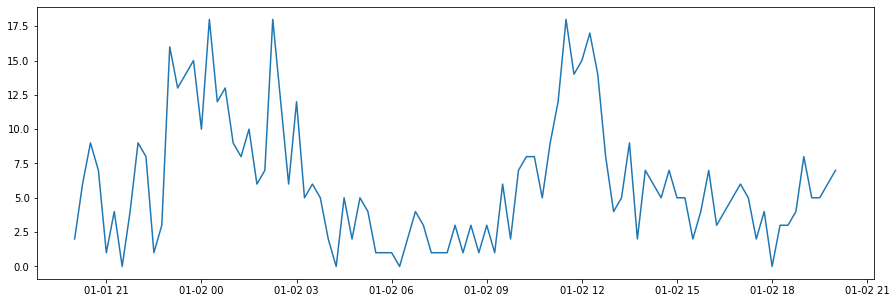

In [129]:
# one day view
plt.figure(figsize = (15,5))
plt.plot(data['1970-01-01 20:00:00':'1970-01-02 20:00:00'])


## Part 2 ‑ Experiment and metrics design

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

**A:**

> 1) How many times each driver crosses the bridge.

> 2) Percentage of drivers passing through the bridge within a certain period.

> 3) If the rider's destination is in another city, what's the acceptance rate of driver?




2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

**A**:A/B testing

> we can select drivers randomly and provide toll-free to one group and in another group, we don't provide toll-free. 
Before the test, set up the baseline. The cross bridge probability ( percentage of drivers crossing the bridge in certain day, week, and month). 

> After completing the experiment, calculate the confidence interval and determine whether we should reject the null or not.
- use Z test. and P-value is lower than 0.05 , then we should reject the null hypothesis.

## Part 3 ‑ Predictive modeling

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [0]:
df2 = pd.read_json ('drive/My Drive/1 myself/springboard 2019-20/Take home/ultimate_data_challenge.json')


In [0]:
df2.loc[:,'last_trip_date'] = pd.to_datetime(df2.loc[:,'last_trip_date'])

In [0]:
df2.loc[:,'signup_date'] = pd.to_datetime(df2.loc[:,'signup_date'])

In [0]:
df2['retention'] = (df2['last_trip_date'] - df2['signup_date'])

In [134]:
df2['last_trip_date']

0       2014-06-17
1       2014-05-05
2       2014-01-07
3       2014-06-29
4       2014-03-15
           ...    
49995   2014-06-05
49996   2014-01-25
49997   2014-05-22
49998   2014-01-15
49999   2014-04-20
Name: last_trip_date, Length: 50000, dtype: datetime64[ns]

In [135]:
df2['signup_date']

0       2014-01-25
1       2014-01-29
2       2014-01-06
3       2014-01-10
4       2014-01-27
           ...    
49995   2014-01-25
49996   2014-01-24
49997   2014-01-31
49998   2014-01-14
49999   2014-01-18
Name: signup_date, Length: 50000, dtype: datetime64[ns]

In [136]:
df2['retention']

0       143 days
1        96 days
2         1 days
3       170 days
4        47 days
          ...   
49995   131 days
49996     1 days
49997   111 days
49998     1 days
49999    92 days
Name: retention, Length: 50000, dtype: timedelta64[ns]

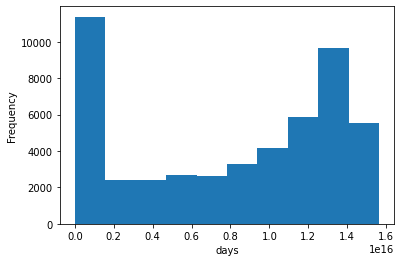

In [137]:
df2['retention'] =df2['retention'].astype('int')
df2['retention'].dropna().plot(kind='hist')
_=plt.xlabel('days')

2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.

In [0]:
df3 = pd.read_json ('drive/My Drive/1 myself/springboard 2019-20/Take home/ultimate_data_challenge.json')

In [139]:
#get dummy data for 6 months

dfdummy = pd.get_dummies(df3.drop(['last_trip_date','signup_date'], axis=1))
dfdummy.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,0,1,0,0,1
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,1,0,0,1,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,1,0,0,0,1
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,0,1,0,0,1
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0,0,1,1,0


In [0]:
from collections import Counter
import numpy as np
c = Counter(df3['last_trip_date'].sort_values())

In [0]:
x = list(map(lambda x: x[-4:], list(c.keys())))

In [0]:
active = df3['last_trip_date'].apply(lambda x: x > '2014-06-01')

In [0]:
from xgboost import XGBClassifier

In [0]:
from sklearn.model_selection import train_test_split

In [145]:
X_train, X_test, y_train, y_test = train_test_split (dfdummy, active, test_size = 0.3, random_state = 0)

clf = XGBClassifier (max_depth =5)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = clf.predict(X_test)

In [147]:
cm2 = metrics.confusion_matrix(y_test, y_pred)
print("confusion matrix:\n",cm2)

confusion matrix:
 [[8315 1232]
 [1793 3660]]


In [148]:
print("Classification Report:\n", metrics.classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       False       0.82      0.87      0.85      9547
        True       0.75      0.67      0.71      5453

    accuracy                           0.80     15000
   macro avg       0.79      0.77      0.78     15000
weighted avg       0.80      0.80      0.80     15000



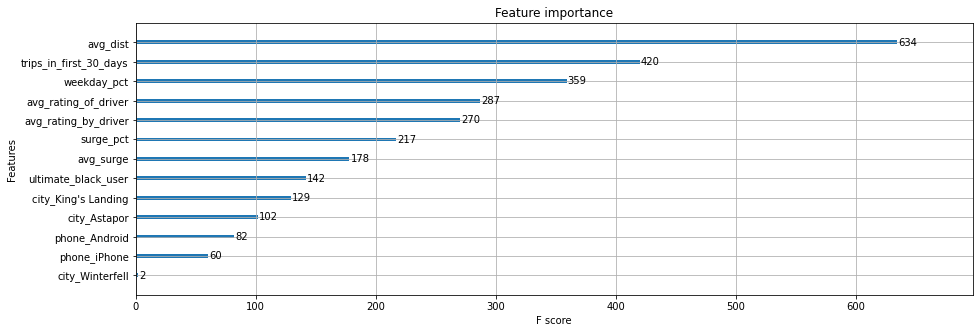

In [149]:
from xgboost import plot_importance
fig,ax = plt.subplots(1,1,figsize=(15,5))
plot_importance(clf,ax=ax)

3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).

**A**


> Based on modeling, average distance seems to be the most important feature.
This is implying that people who make trip in local area might be remained more in active. If we do advertisement focused on local area, it might be helpful to increase the retention rate.

